# Smoke Detection

### Detect smoke with the help of IOT data and trigger a fire alarm.

**Problem Type** : Binary Classification

**Target Variable** : Fire Alarm

[**Smoke Detection Kaggle Dataset**](https://www.kaggle.com/datasets/deepcontractor/smoke-detection-dataset)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.dummy import DummyClassifier
import bentoml

In [2]:
data = Path("./dataset/")

In [3]:
list(data.glob("*.csv"))

[PosixPath('dataset/smoke_detection_iot.csv')]

In [4]:
df = pd.read_csv(data / "smoke_detection_iot.csv", index_col=0)
df.head()

,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0
2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2,0
3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,3,0
4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,4,0


## EDA

- Checking missing values
- Look at the target value(Fire Alarm)
- Feature importance: Correlation


In [5]:
df.shape

(62630, 15)

The dataset has 62630 observations and 15 features

In [6]:
df.dtypes

UTC                 int64
Temperature[C]    float64
Humidity[%]       float64
TVOC[ppb]           int64
eCO2[ppm]           int64
Raw H2              int64
Raw Ethanol         int64
Pressure[hPa]     float64
PM1.0             float64
PM2.5             float64
NC0.5             float64
NC1.0             float64
NC2.5             float64
CNT                 int64
Fire Alarm          int64
dtype: object

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62630 entries, 0 to 62629
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   UTC             62630 non-null  int64  
 1   Temperature[C]  62630 non-null  float64
 2   Humidity[%]     62630 non-null  float64
 3   TVOC[ppb]       62630 non-null  int64  
 4   eCO2[ppm]       62630 non-null  int64  
 5   Raw H2          62630 non-null  int64  
 6   Raw Ethanol     62630 non-null  int64  
 7   Pressure[hPa]   62630 non-null  float64
 8   PM1.0           62630 non-null  float64
 9   PM2.5           62630 non-null  float64
 10  NC0.5           62630 non-null  float64
 11  NC1.0           62630 non-null  float64
 12  NC2.5           62630 non-null  float64
 13  CNT             62630 non-null  int64  
 14  Fire Alarm      62630 non-null  int64  
dtypes: float64(8), int64(7)
memory usage: 7.6 MB


Cleaning feature column names

In [8]:
df.columns = (
    df.columns.str.lower()
    .str.replace(" ", "_", regex=False)
    .str.replace("[", "_", regex=False)
    .str.replace("]", "_", regex=False)
    .str.replace("%", "pct", regex=False)
    .str.replace(".", "_", regex=False)
)

In [9]:
df.columns

Index(['utc', 'temperature_c_', 'humidity_pct_', 'tvoc_ppb_', 'eco2_ppm_',
       'raw_h2', 'raw_ethanol', 'pressure_hpa_', 'pm1_0', 'pm2_5', 'nc0_5',
       'nc1_0', 'nc2_5', 'cnt', 'fire_alarm'],
      dtype='object')

In [10]:
df.head()

,utc,temperature_c_,humidity_pct_,tvoc_ppb_,eco2_ppm_,raw_h2,raw_ethanol,pressure_hpa_,pm1_0,pm2_5,nc0_5,nc1_0,nc2_5,cnt,fire_alarm
0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0
2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2,0
3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,3,0
4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,4,0


#### Dropping the timestamp column

In [11]:
df.drop(columns=["utc"], inplace=True)

In [12]:
df.describe()

,temperature_c_,humidity_pct_,tvoc_ppb_,eco2_ppm_,raw_h2,raw_ethanol,pressure_hpa_,pm1_0,pm2_5,nc0_5,nc1_0,nc2_5,cnt,fire_alarm
count,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000
mean,15.970424,48.539499,1942.057528,670.021044,12942.453936,19754.257912,938.627649,100.594309,184.467770,491.463608,203.586487,80.049042,10511.386157,0.714626
std,14.359576,8.865367,7811.589055,1905.885439,272.464305,609.513156,1.331344,922.524245,1976.305615,4265.661251,2214.738556,1083.383189,7597.870997,0.451596
min,-22.010000,10.740000,0.000000,400.000000,10668.000000,15317.000000,930.852000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.994250,47.530000,130.000000,400.000000,12830.000000,19435.000000,938.700000,1.280000,1.340000,8.820000,1.384000,0.033000,3625.250000,0.000000
50%,20.130000,50.150000,981.000000,400.000000,12924.000000,19501.000000,938.816000,1.810000,1.880000,12.450000,1.943000,0.044000,9336.000000,1.000000
75%,25.409500,53.240000,1189.000000,438.000000,13109.000000,20078.000000,939.418000,2.090000,2.180000,14.420000,2.249000,0.051000,17164.750000,1.000000
max,59.930000,75.200000,60000.000000,60000.000000,13803.000000,21410.000000,939.861000,14333.690000,45432.260000,61482.030000,51914.680000,30026.438000,24993.000000,1.000000


In [13]:
df.fire_alarm.value_counts(normalize=True)

1    0.714626
0    0.285374
Name: fire_alarm, dtype: float64

We see that 71% most the of the time a fire alarm is triggered

In [14]:
df["fire_alarm"].head()

0    0
1    0
2    0
3    0
4    0
Name: fire_alarm, dtype: int64

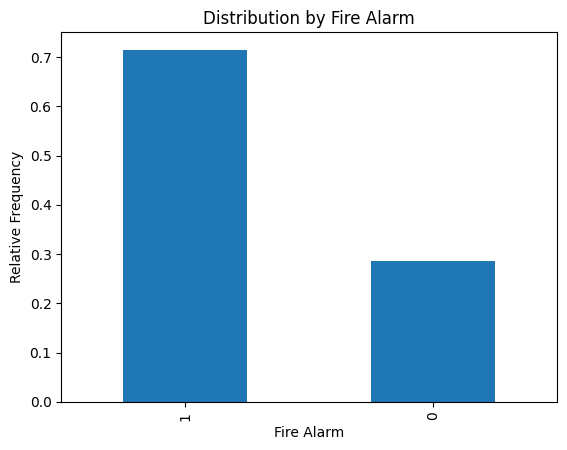

In [15]:
df["fire_alarm"].value_counts(normalize=True).plot(
    kind="bar",
    xlabel="Fire Alarm",
    ylabel="Relative Frequency",
    title="Distribution by Fire Alarm"
);

In [16]:
corr = df.drop(columns="fire_alarm").corr()
corr

,temperature_c_,humidity_pct_,tvoc_ppb_,eco2_ppm_,raw_h2,raw_ethanol,pressure_hpa_,pm1_0,pm2_5,nc0_5,nc1_0,nc2_5,cnt
temperature_c_,1.000000,-0.243986,0.082442,0.079265,-0.135540,-0.037343,-0.251203,0.037330,0.032084,0.039291,0.031608,0.025526,-0.089850
humidity_pct_,-0.243986,1.000000,-0.488878,-0.369095,0.247199,0.068782,0.694614,-0.236538,-0.178882,-0.277389,-0.174224,-0.118502,0.251965
tvoc_ppb_,0.082442,-0.488878,1.000000,0.606118,-0.653053,-0.673715,-0.220004,0.597366,0.477424,0.670657,0.467386,0.344721,-0.057703
eco2_ppm_,0.079265,-0.369095,0.606118,1.000000,-0.682785,-0.506695,-0.326043,0.665482,0.572691,0.699604,0.564252,0.456323,-0.106681
raw_h2,-0.135540,0.247199,-0.653053,-0.682785,1.000000,0.631495,0.303090,-0.530714,-0.431079,-0.587769,-0.422626,-0.318518,-0.031036
raw_ethanol,-0.037343,0.068782,-0.673715,-0.506695,0.631495,1.000000,-0.075926,-0.480698,-0.393192,-0.529186,-0.385720,-0.293351,-0.511995
pressure_hpa_,-0.251203,0.694614,-0.220004,-0.326043,0.303090,-0.075926,1.000000,-0.258938,-0.243071,-0.248657,-0.241148,-0.213390,0.186290
pm1_0,0.037330,-0.236538,0.597366,0.665482,-0.530714,-0.480698,-0.258938,1.000000,0.956118,0.940045,0.949860,0.854901,-0.093700
pm2_5,0.032084,-0.178882,0.477424,0.572691,-0.431079,-0.393192,-0.243071,0.956118,1.000000,0.798873,0.999787,0.969382,-0.083869
nc0_5,0.039291,-0.277389,0.670657,0.699604,-0.587769,-0.529186,-0.248657,0.940045,0.798873,1.000000,0.786274,0.626711,-0.094741


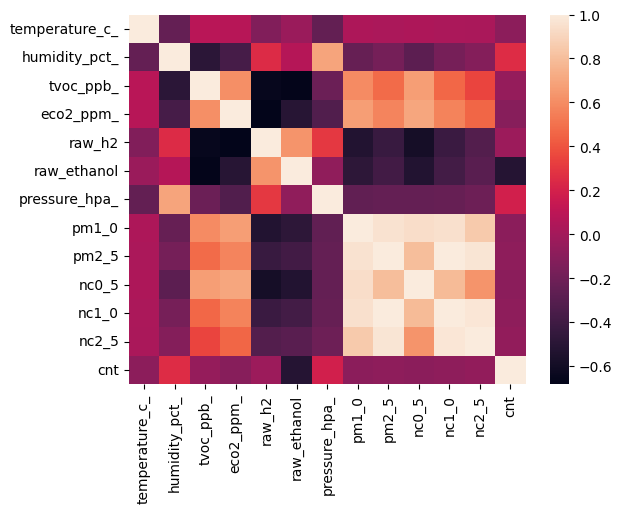

In [17]:
sns.heatmap(corr);

## Data Split (Setting up the validation framework)

In [18]:
target = "fire_alarm"
X = df.drop(columns=target)
y = df[target]

In [19]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [20]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42
)

In [21]:
X.shape, X_train.shape, X_test.shape, X_val.shape

((62630, 13), (37578, 13), (12526, 13), (12526, 13))

## Build Model

### Baseline

In [22]:
y_train.value_counts(normalize=True).max()

0.715737931768588

In [23]:
dummy_model = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_model.fit(X_train, y_train)

DummyClassifier(random_state=42, strategy='most_frequent')

In [24]:
dummy_model.score(X_test, y_test)

0.7130768002554686

We see that our baseline model has an accuracy of 71% if it were to predict the most frequent value all the time.

### Iterate and Evaluate

- Train and select the best performant model.
- Using StandardScaler transformer so that the features have a standard scale.

#### Logistic Regression

In [25]:
lg_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, random_state=42)
)
lg_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [26]:
lg_model.predict(X_test[:10])

array([1, 1, 0, 1, 1, 1, 0, 1, 1, 0])

In [27]:
list(y_test.iloc[:10])

[1, 1, 0, 1, 1, 1, 0, 1, 1, 0]

In [28]:
lg_model.score(X_test, y_test)

0.9902602586619831

In [29]:
accuracy_score(y_test, lg_model.predict(X_test))

0.9902602586619831

In [30]:
roc_auc_score(y_test, lg_model.predict(X_test))

0.9876000915592764

In [31]:
# validate and generalize
lg_model.score(X_val, y_val)

0.9905795944435574

In [32]:
accuracy_score(y_val, lg_model.predict(X_val))

0.9905795944435574

In [33]:
roc_auc_score(y_val, lg_model.predict(X_val))

0.9879138278426856

Our logistic classification model performs way more better that the base by more than 20%

#### Cross validation

In [34]:
cv_result = cross_validate(lg_model, X, y, cv=5)
cv_result

{'fit_time': array([0.19474888, 0.30971503, 0.32571125, 0.22951198, 0.14888287]),
 'score_time': array([0.00330591, 0.00389099, 0.00307584, 0.00311399, 0.0031662 ]),
 'test_score': array([0.93804886, 0.99704614, 0.83202938, 0.99225611, 0.91018681])}

In [35]:
scores = cv_result["test_score"]
print(
    "The mean cross-validation accuracy is: "
    f"{scores.mean():.3f} +/- {scores.std():.3f}"
)

The mean cross-validation accuracy is: 0.934 +/- 0.061


#### Descision Tree

In [36]:
depth_hyperparams = range(1, 50, 2)
# Create empty lists for training and validation accuracy scores
training_acc = []
validation_acc = []

for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    dt_model = make_pipeline(
        StandardScaler(),
        DecisionTreeClassifier(max_depth=d, random_state=42)
    )
    # Fit model to training data
    dt_model.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(dt_model.score(X_train, y_train))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(dt_model.score(X_val, y_val))

print("Training Accuracy Scores:", training_acc[:10])
print("Validation Accuracy Scores:", validation_acc[:10])

Training Accuracy Scores: [0.8990100590771196, 0.975836925860876, 0.9868007876949279, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Validation Accuracy Scores: [0.9024429187290436, 0.9751716429825962, 0.9869870669008463, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


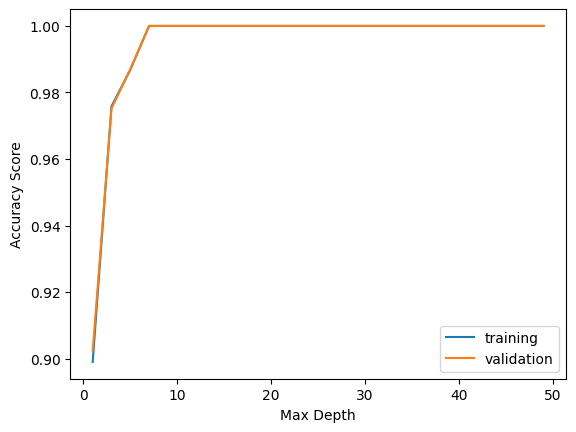

In [37]:
# Plot `depth_hyperparams`, `training_acc`
plt.plot(depth_hyperparams, training_acc, label="training")
plt.plot(depth_hyperparams, validation_acc, label="validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.legend();

In [38]:
dt_model = make_pipeline(
        StandardScaler(),
        DecisionTreeClassifier(max_depth=6, random_state=42)
    )
# Fit model to training data
dt_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=6, random_state=42))])

In [39]:
accuracy_score(y_test, dt_model.predict(X_test))

1.0

In [40]:
# validate and generalize
accuracy_score(y_val, dt_model.predict(X_val))

0.9998403321092129

In [41]:
roc_auc_score(y_val, dt_model.predict(X_val))

0.999888005375742

In [42]:
cv_result = cross_validate(dt_model, X, y, cv=5)
cv_result

{'fit_time': array([0.10738587, 0.09153414, 0.08547306, 0.10146093, 0.07234812]),
 'score_time': array([0.00351405, 0.0035913 , 0.0035038 , 0.00342679, 0.003407  ]),
 'test_score': array([0.99840332, 0.99712598, 0.7951461 , 1.        , 0.91018681])}

In [43]:
scores = cv_result["test_score"]
print(
    "The mean cross-validation accuracy is: "
    f"{scores.mean():.3f} +/- {scores.std():.3f}"
)

The mean cross-validation accuracy is: 0.940 +/- 0.080


The Decision tree model also performs better than the logistic model

#### Random Forest

In [44]:
training_acc = []
validation_acc = []
for n in range(10, 201, 10):
    rf_model = make_pipeline(
        StandardScaler(),
        RandomForestClassifier(n_estimators=n, random_state=42)
    )
    # Fit model to training data
    rf_model.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(rf_model.score(X_train, y_train))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(rf_model.score(X_val, y_val))

print("Training Accuracy Scores:", training_acc[:10])
print("Validation Accuracy Scores:", validation_acc[:10])

Training Accuracy Scores: [0.9999733886848688, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Validation Accuracy Scores: [0.9998403321092129, 0.9999201660546064, 0.9999201660546064, 0.9999201660546064, 0.9999201660546064, 1.0, 1.0, 1.0, 1.0, 1.0]


In [45]:
training_acc = []
validation_acc = []
for d in depth_hyperparams:
    rf_model = make_pipeline(
        StandardScaler(),
        RandomForestClassifier(n_estimators=25, max_depth=d, random_state=42)
    )
    # Fit model to training data
    rf_model.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(rf_model.score(X_train, y_train))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(rf_model.score(X_val, y_val))

print("Training Accuracy Scores:", training_acc[:10])
print("Validation Accuracy Scores:", validation_acc[:10])

Training Accuracy Scores: [0.8743945925807654, 0.9996274415881633, 0.9998137207940816, 0.9999733886848688, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Validation Accuracy Scores: [0.8784927351109691, 0.9995209963276385, 0.9996008302730321, 0.9998403321092129, 0.9999201660546064, 0.9999201660546064, 0.9999201660546064, 0.9999201660546064, 0.9999201660546064, 0.9999201660546064]


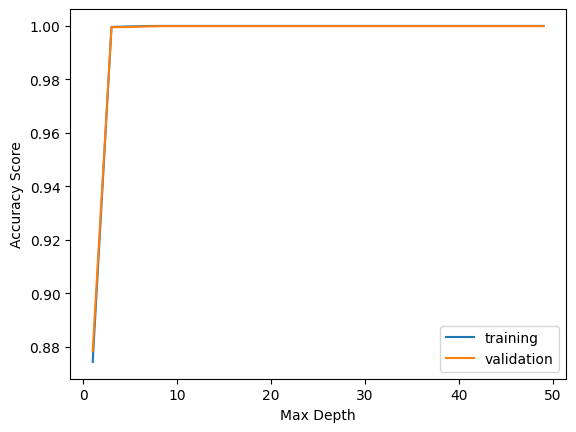

In [46]:
# Plot `depth_hyperparams`, `training_acc`
plt.plot(depth_hyperparams, training_acc, label="training")
plt.plot(depth_hyperparams, validation_acc, label="validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.legend();

In [47]:
rf_model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_estimators=25, max_depth=10, random_state=42)
)
# Fit model to training data
rf_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, n_estimators=25,
                                        random_state=42))])

In [48]:
accuracy_score(y_test, rf_model.predict(X_test))

1.0

In [49]:
# validate and generalize
accuracy_score(y_val, rf_model.predict(X_val))

0.9999201660546064

In [50]:
roc_auc_score(y_val, rf_model.predict(X_val))

0.9998609952738393

In [51]:
cv_result = cross_validate(rf_model, X, y, cv=5)
cv_result

{'fit_time': array([0.98899913, 0.90432   , 0.90301013, 0.90429282, 0.68477368]),
 'score_time': array([0.02588582, 0.022614  , 0.02180672, 0.01842093, 0.0167892 ]),
 'test_score': array([1.        , 0.99736548, 0.99992017, 1.        , 0.91018681])}

In [52]:
scores = cv_result["test_score"]
print(
    "The mean cross-validation accuracy is: "
    f"{scores.mean():.3f} +/- {scores.std():.3f}"
)

The mean cross-validation accuracy is: 0.981 +/- 0.036


We will take the Random Forest model as our best model

### Save and serve the model with bentoml

In [53]:
bentoml.sklearn.save_model(
    "smoke_detection",
    rf_model
)

Model(tag="smoke_detection:siv7dosv46nd3chj", path="/Users/patrickwalukagga/bentoml/models/smoke_detection/siv7dosv46nd3chj/")

In [54]:
!bentoml models get smoke_detection:d4amgmsvz2gptchj --output=json

{
  "name": "smoke_detection",
  "version": "d4amgmsvz2gptchj",
  "module": "bentoml.sklearn",
  "labels": {},
  "options": {},
  "metadata": {},
  "context": {
    "framework_name": "sklearn",
    "framework_versions": {
      "scikit-learn": "1.1.2"
    },
    "bentoml_version": "1.0.7",
    "python_version": "3.9.13"
  },
  "signatures": {
    "predict": {
      "batchable": false
    }
  },
  "api_version": "v1",
  "creation_time": "2022-10-27T08:05:29.012853+00:00"
}


In [55]:
!bentoml models list

 Tag                           Module           Size        Creation Time       
 smoke_detection:siv7dosv46n…  bentoml.sklearn  121.64 KiB  2022-10-27 14:07:39 
 smoke_detection:odroiwsv4kd…  bentoml.sklearn  121.64 KiB  2022-10-27 13:30:56 
 smoke_detection:d4amgmsvz2g…  bentoml.sklearn  121.64 KiB  2022-10-27 11:05:29 
 smoke_detection:sl7eeccvm67…  bentoml.sklearn  121.64 KiB  2022-10-26 22:51:25 
 credit_risk_model:ssuzyxsok…  bentoml.xgboost  197.77 KiB  2022-10-17 22:33:30 
 credit_risk_model:ftxkumcog…  bentoml.xgboost  197.80 KiB  2022-10-17 19:10:10 
 credit_risk_model:tdssyfcod…  bentoml.xgboost  197.77 KiB  2022-10-17 16:14:14 
 mlzoomcamp_homework:jsi67fs…  bentoml.sklearn  5.82 KiB    2022-10-14 17:48:43 
 mlzoomcamp_homework:qtzdz3s…  bentoml.sklearn  5.79 KiB    2022-10-13 23:42:14 


In [56]:
import json

In [57]:
request = X.iloc[100].to_dict()
print(json.dumps(request, indent=2))

{
  "temperature_c_": 21.388,
  "humidity_pct_": 54.95,
  "tvoc_ppb_": 19.0,
  "eco2_ppm_": 414.0,
  "raw_h2": 12527.0,
  "raw_ethanol": 19613.0,
  "pressure_hpa_": 939.796,
  "pm1_0": 0.11,
  "pm2_5": 0.33,
  "nc0_5": 0.19,
  "nc1_0": 0.382,
  "nc2_5": 0.218,
  "cnt": 100.0
}


In [60]:
data = {
  "temperature_c_": 21.388,
  "humidity_pct_": 54.95,
  "tvoc_ppb_": 19.0,
  "eco2_ppm_": 414.0,
  "raw_h2": 12527.0,
  "raw_ethanol": 19613.0,
  "pressure_hpa_": 939.796,
  "pm1_0": 0.11,
  "pm2_5": 0.33,
  "nc0_5": 0.19,
  "nc1_0": 0.382,
  "nc2_5": 0.218,
  "cnt": 100.0
}
X_data = pd.DataFrame(data, index=[0])
model_ref = bentoml.sklearn.get("smoke_detection:siv7dosv46nd3chj")
model_runner = model_ref.to_runner()
model_runner.init_local()
model_runner.predict.run(X_data)

'Runner.init_local' is for debugging and testing only.


array([0])